In [ ]:
# Hugginface playground

import os
from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from adapters import AutoAdapterModel, list_adapters

login(token=os.getenv('HF_READ_TOKEN'))
model_id = 'mistralai/Mistral-7B-v0.1'

# ls -la /c/Users/Siarhei_Kushniaruk/.cache/huggingface
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForCausalLM.from_pretrained(model_id, trust_remote_code=True).to('cpu')
model.eval()

adapter_infos = list_adapters(source='hf', model_name=model_id)
for adapter_info in adapter_infos:
    print('Id:', adapter_info.adapter_id)
    print('Model name:', adapter_info.model_name)
    print('Uploaded by:', adapter_info.username)
# model = AutoAdapterModel.from_pretrained(model_id)
# adapter_name = model.load_adapter('AdapterHub/roberta-base-pf-imdb', source='hf')
# model.active_adapters = adapter_name

chat = [
    'How to write a unit tests on Python project',
    'Use PyTest and Spark'
]
print(f'tokens: {tokenizer.tokenize(chat)}')
print(f'ids: {tokenizer.convert_tokens_to_ids(tokenizer.tokenize(chat))}')
print(f'summary: {tokenizer(chat, return_tensors='pt').to('cpu')}')
print(f'decoded: {tokenizer.decode(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(chat)))}')

pipe = pipeline('text-generation', model=model, tokenizer=tokenizer)
res = pipe(chat, temperature=0.8, top_p=0.9)
for message in res:
    print(message[0]['generated_text'])

tokenizer_config.json:   0%|          | 0.00/996 [00:00<?, ?B/s]

c:\Users\Siarhei_Kushniaruk\Desktop\AI_learning\.venv\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Siarhei_Kushniaruk\.cache\huggingface\hub\models--mistralai--Mistral-7B-v0.1. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not instal

tokenizer.model:   0%|          | 0.00/493k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 2 files:   0%|          | 0/2 [00:00<?, ?it/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model-00002-of-00002.safetensors:   0%|          | 0.00/4.54G [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/9.94G [00:00<?, ?B/s]

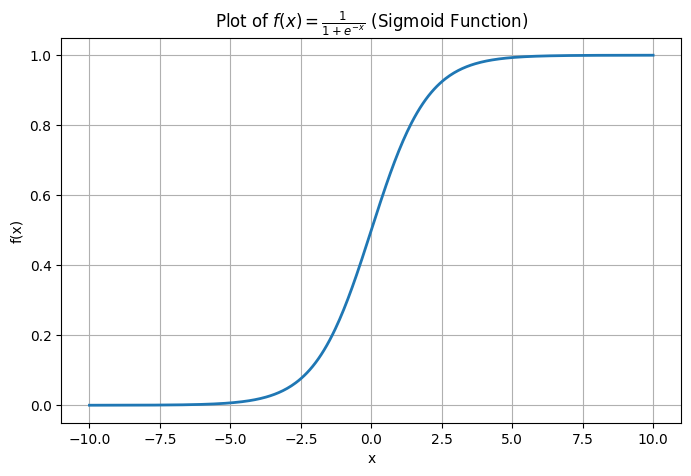

In [1]:
# plot sigmoid function

import numpy as np
import matplotlib.pyplot as plt

# Define the function
x = np.linspace(-10, 10, 400)
y = 1 / (1 + np.exp(-x))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(x, y, linewidth=2)
plt.title(r'Plot of $f(x) = \frac{1}{1 + e^{-x}}$ (Sigmoid Function)')
plt.xlabel('x')
plt.ylabel('f(x)')
plt.grid(True)
plt.show()

In [ ]:
# LoRA fine-tuning

import hf_xet
from transformers import AutoModelForCausalLM, AutoTokenizer, Trainer, TrainingArguments
from peft import get_peft_model, LoraConfig, TaskType
from datasets import load_dataset

try:
    print('>>> Load LLM')
    model_name = 'gpt2'
    tokenizer = AutoTokenizer.from_pretrained(model_name)
    model = AutoModelForCausalLM.from_pretrained(model_name, device_map='auto')

    peft_config = LoraConfig(
        task_type=TaskType.CAUSAL_LM,
        inference_mode=False,
        fan_in_fan_out=True,
        r=8,
        lora_alpha=16,
        lora_dropout=0.05
    )
    model = get_peft_model(model, peft_config)

    def tokenize_fn(examples):
        return tokenizer(examples['text'], truncation=True, padding='max_length', max_length=512)

    print('>>> Tokenize loaded datasets')
    dataset = load_dataset('mteb/tweet_sentiment_extraction')
    tokenizer.pad_token = tokenizer.eos_token
    tokenized_datasets = dataset.map(tokenize_fn, batched=True)

    training_args = TrainingArguments(
        output_dir='./LoRA_output',
        per_device_train_batch_size=4,
        num_train_epochs=3,
        save_steps=100,
        seed=42,
        fp16=True,
        dataloader_pin_memory=False,
        dataloader_num_workers=0
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        processing_class=tokenizer,
        train_dataset=tokenized_datasets['train']
    )

    print('>>> Training')
    trainer.train()

    print('>>> Validating')
    trainer.evaluate()
except Exception as e:
    print(e)

In [ ]:
# GGUF quantization


# Import necessary libraries
import torch
import torch.nn as nn
import torch.quantization as quant

# Step 1: Define a simple neural network model in PyTorch
class SimpleModel(nn.Module):
    def __init__(self):
        super(SimpleModel, self).__init__()
        self.fc1 = nn.Linear(10, 50)  # First fully connected layer
        self.fc2 = nn.Linear(50, 20)  # Second fully connected layer
        self.fc3 = nn.Linear(20, 5)   # Output layer

    def forward(self, x):
        x = torch.relu(self.fc1(x))   # ReLU activation after first layer
        x = torch.relu(self.fc2(x))   # ReLU activation after second layer
        x = self.fc3(x)               # Output layer
        return x

# Step 2: Initialize the model and switch to evaluation mode
model = SimpleModel()
model.eval()


torch.save(model, './LLMs/simple_model.pth')

quantized_model = torch.ao.quantization.quantize_dynamic(
    model, {nn.Linear},
    dtype=torch.qint8
)
torch.save(quantized_model, './LLMs/quantized_simple_model.pth')


dummy_input = torch.randn(1, 10)
print('Dummy input', dummy_input)
print('Model output:', model(dummy_input))
print('Quantized model output:', quantized_model(dummy_input))